In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('../..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd
import spacy
import clean_dataset as clean
import make_dataset as mk
import vectorize_embed as em
import tools as tools
#import pickle5 as pickle
import pickle
import numpy as np

from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix



[nltk_data] Downloading package stopwords to C:\Users\Jonas
[nltk_data]     Nothnagel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Jonas
[nltk_data]     Nothnagel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [8]:
'''import data'''
df = pd.read_json(os.path.abspath(os.path.join('../..', 'data/processed/encoded_labels'))+'/technical_team_all.json')

'''lowercase data'''
df['all_text_clean'] = df['all_text_clean'].apply(clean.basic)

'''stop words'''
df['text_stop'] = df['all_text_clean'].apply(clean.tidy)
#tidy(text, http = True, punc = True, lem = True, stop_w = True):

'''replace abbrevation for testing:'''
df['all_text_clean'] = df['all_text_clean'].apply(clean.replace_abb)

In [22]:
names = ['chemicals_and_waste_programme', 'climate_change_adaptation_programme',
       'climate_forest_of_climate_change_mitigation',
       'climate_strategies_and_policy_programme',
       'ecosystems_and_biodiversity_programme',
       'energy_program_of_climate_change_mitigation',
       'oceans_and_water_programme',]

In [11]:
df = mk.truncate(df, 550, printing = False)

'''remove french entries'''
df = clean.detect_lang(df, "fr", printing =False)

'''remove spanish entries'''
df = clean.detect_lang(df, "es", printing =False)

In [13]:
df, df_lambda = tools.count_labels (df)

#df.to_excel(os.path.abspath(os.path.join('../..', 'data/processed'))+"/technical_team_multi_class.xlsx")

Shape:(7, 2)


,category,Count
0,chemicals_and_waste_programme,38
1,climate_change_adaptation_programme,145
2,climate_forest_of_climate_change_mitigation,24
3,climate_strategies_and_policy_programme,14
4,ecosystems_and_biodiversity_programme,182
5,energy_program_of_climate_change_mitigation,103
6,oceans_and_water_programme,39


## split into train and validation data and build feature space:

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df['all_text_clean_spacy'],
                                                    df['cat'].values,
                                                    test_size = .3,
                                                    stratify=df['cat'].values,
                                                    random_state = 1,
                                                    shuffle = True)
print('train size:', len(X_train))
print('test size:', len(X_test))

assert len(set(y_train)) == len(set(y_test)), "Unequal splits with some labels missing"

'''extract features using tfidf vecorization:'''
vectorizer = TfidfVectorizer(ngram_range = (1,3),min_df = 0.01, max_df = 0.95)
vect = vectorizer.fit(X_train)
X_train = vect.transform(X_train)
X_test = vect.transform(X_test)

train size: 381
test size: 164


Training accuracy: 97.0 %
Test accuracy: 92.0 %


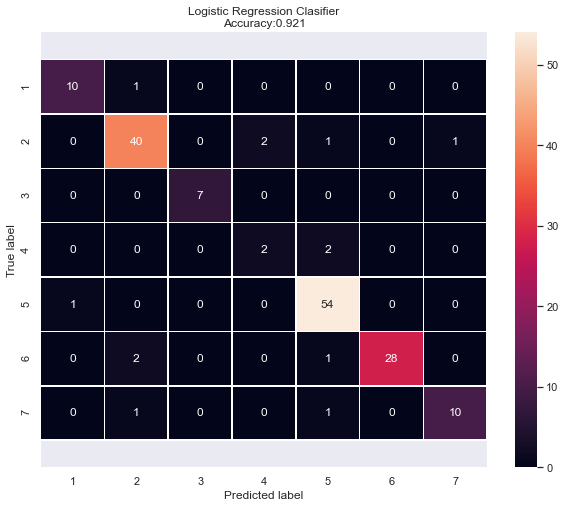

In [24]:
clf = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial', class_weight="balanced").fit(X_train, y_train)
print('Training accuracy:', clf.score(X_train, y_train).round(2)*100, "%")
print('Test accuracy:', clf.score(X_test, y_test).round(2)*100, "%")
y_hat = clf.predict(X_test)
tools.show_labels(y_test, y_hat, title = 'Logistic Regression Clasifier', class_range = (1,8))

In [17]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.91      0.91      0.91        44
           2       1.00      1.00      1.00         7
           3       0.50      0.50      0.50         4
           4       0.92      0.98      0.95        55
           5       1.00      0.90      0.95        31
           6       0.91      0.83      0.87        12

    accuracy                           0.92       164
   macro avg       0.88      0.86      0.87       164
weighted avg       0.92      0.92      0.92       164



In [18]:
df_lambda = tools.get_topwords(clf, vectorizer, n = 10, n_models = 7, show_idxmax = True)
print(f'Shape:{df_lambda.shape}')
display(df_lambda)

label_1              pcb
label_2          climate
label_3    environmental
label_4        community
label_5               pa
label_6           energy
label_7              sap
dtype: object

Shape:(7, 1)


,Keywords
label_1,"[(pcb, 2.101), (mercury, 1.799), (pop, 1.684),..."
label_2,"[(climate, 2.673), (climate change, 1.472), (a..."
label_3,"[(environmental, 2.411), (rio, 1.447), (global..."
label_4,"[(community, 1.673), (landscape, 1.564), (sgp,..."
label_5,"[(pa, 1.227), (biodiversity, 1.074), (conserva..."
label_6,"[(energy, 2.06), (eop, 1.248), (urban, 0.89), ..."
label_7,"[(sap, 1.726), (water, 1.325), (basin, 1.266),..."


In [20]:

key = df_lambda.Keywords.tolist()

## Notes:
* class weight balanced increases results a lot.
* using truncated data_set also helps.